<a href="https://colab.research.google.com/github/Klein225/Option-Pricing-Using-Neural-Networks/blob/master/European_Call_in_Black_%26_Scholes_(Antione_Final)_ipnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Europen Call in Black-Scholes-Merton**

We will show the limitations of linear regression when it comes to predicting the call price of a simple vanilla call option given the Black Scholes Formula.

Firstly we simulate the training set under the Black & Scholes Dynamics:

$$
\begin{array}{l}
{S_1} = X = {S_0}\exp \left( {\frac{{ - {\sigma_0^2 T_1}}}{2} + {\sigma}_0 \sqrt{T1} {N_1}} \right)\\
{S_2} = {S_1}\exp \left( {\frac{{ - {\sigma ^2 \left(T_2-T_1\right)}}}{2} + \sigma \sqrt{T_2-T_1} {N_2}} \right)\\
Y = \max \left( {0,{S_2} - K} \right)
\end{array}
$$

where $N_1$ and $N_2$ are independent standard Gaussians. (Note: we are simulating under a GBM from which BS is derived)

**<h3><center>Simulation of the training set</center></h3>**

In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# recall that there are no dividends, interestrates etc. and we have a fixed strike, vol and expiry
simulations = 50000

T1 = 1.0
T2 = 2.0
K = 110.0

spot = 100.0
vol0 = 0.5 #sigma at time 0
vol = 0.2 #sigma at time 1

In [0]:
np.random.seed(42)

returns = np.random.normal(size = [simulations, 2])

S1 = spot * np.exp(-0.5 *vol0**2 * T1 + vol0 * np.sqrt(T1) * returns[:,0])

S2 = S1 * np.exp(-0.5 * vol**2 * (T2-T1) + vol * np.sqrt(T2-T1) * returns[:,1])

X = S1
Y = np.maximum(0, S2 - K)

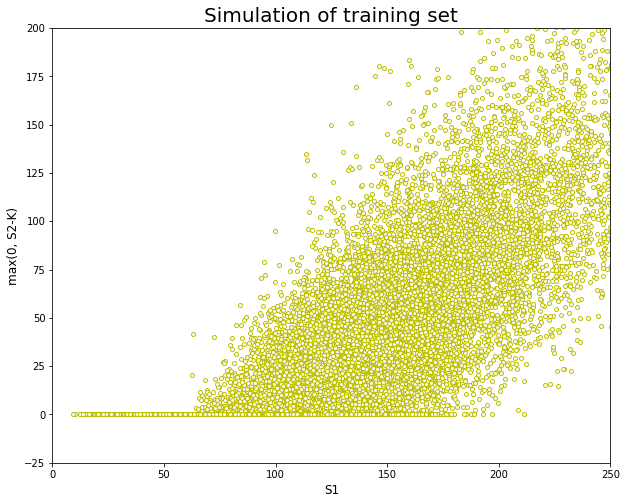

In [0]:
plt.figure(figsize=(10,8))
plt.plot(X, Y, 'yo', markersize=4, markerfacecolor="white")
plt.xlabel("S1", fontsize=12)
plt.ylabel("max(0, S2-K)", fontsize=12)
plt.axis([0, 250, -25, 200])
plt.title('Simulation of training set', fontsize=20,)
plt.show()

**<h3><center>Linear Regression</center></h3>**

Recall that the equation for simple linear regression is givena as:
$$
\begin{array}{l}
\hat y = E[y|x] = b+ \sum_{i=1}^{n} w_ix_i = b + w^Tx
\end{array}
$$
where b is the intercet and m is the slope of the line. So basically, the linear regression algorithm gives us the most optimal value for the intercept and the slope (in two dimensions). The y and x variables remain the same, since they are the data features and cannot be changed. The values that we can control are the intercept and slope. There can be multiple straight lines dependin upon the values of intercept and slope. Basically what the linear regression algorithm does is it fits multiple kunes on the data points and returns the line that results in the least error.

(Linear regresion obviously fails to approximate the correct function because it cannot capture linearities.)

**<h3><center>Polynomial Regression</center></h3>**

A solution to the above linear regression is to regress not on x, but on basis functions a of x.

An example of this could be to use polynomial regression. Polynomial regression is a form of linear regression in which the relationship between the independent variable x and the dependent variable y is mideled as an nth degree polynomial. Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y, denoted E(y|x).

In [0]:
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [0]:
# Number of degrees
degrees = 6

poly_features = PolynomialFeatures(degree=degrees, include_bias= False)
XX = X.reshape(-1,1)
x_poly = poly_features.fit_transform(XX)
XX[0]
x_poly[0]

array([1.13128831e+02, 1.27981323e+04, 1.44783774e+06, 1.63792190e+08,
       1.85296189e+10, 2.09623412e+12])

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(x_poly, Y)
lin_reg.intercept_, lin_reg.coef_

(-3.9284434133107666,
 array([ 5.15138784e-01, -1.63768549e-02,  1.84060656e-04, -7.47029283e-07,
         1.32619981e-09, -8.60894689e-13]))

In [0]:
x_new = np.linspace(20, 250, 100).reshape(100,1)
x_new_poly = poly_features.transform(x_new)
y_new = lin_reg.predict(x_new_poly)

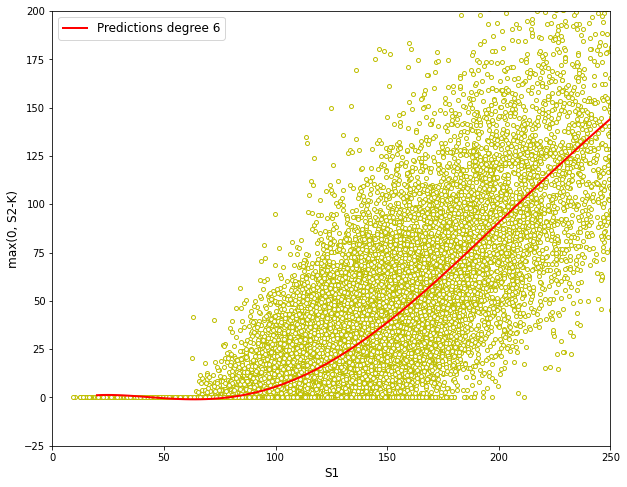

In [0]:
plt.figure(figsize=(10,8))
plt.plot(X, Y, 'yo', markersize=4, markerfacecolor="white")
plt.plot(x_new, y_new, "r-", linewidth=2, label="Predictions degree 6")
plt.xlabel("S1", fontsize=12)
plt.ylabel("max(0, S2-K)", fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.axis([0, 250, -25, 200])
plt.show()

<h3><center>Black & Scholes' formula</center></h3>

To asses the accuracy of the polynomial regression, we implement the Black Scholes formula which is the correct result:

$$
B{S_{K,T,\sigma }}\left( S \right) = SN\left( {\frac{{\log \left( {\frac{S}{K}} \right) + \frac{{{\sigma ^2 T}}}{2}}}{\sigma \sqrt{T} }} \right) - KN\left( {\frac{{\log \left( {\frac{S}{K}} \right) - \frac{{{\sigma ^2 T}}}{2}}}{\sigma\sqrt{T} }} \right)
$$

In [0]:
from scipy.stats import norm

In [0]:
def BlackSchoesCall(spot, strike, vol, T):
  d1 = (np.log(spot / strike) + 0.5*vol**2*T) / (vol*np.sqrt(T))
  d2 = (np.log(spot / strike) - 0.5*vol**2*T) / (vol*np.sqrt(T))

  return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsc(spot):
  return BlackSchoesCall(spot, K, vol, T2-T1)

#Test
print("%.4f" % BlackSchoesCall(100,100, .1, 1.))

3.9878


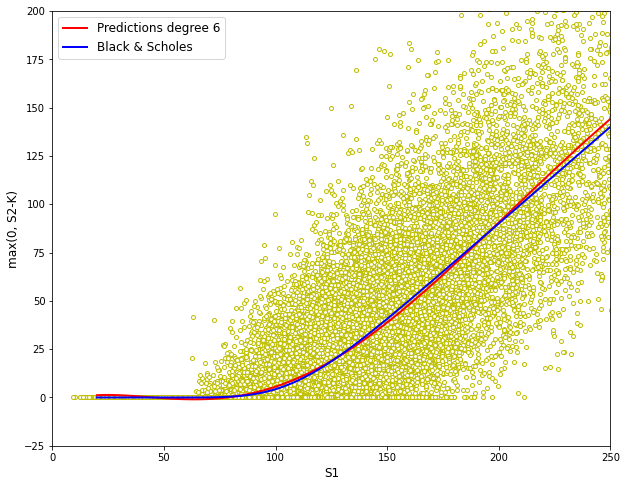

In [0]:
target = bsc(x_new)

plt.figure(figsize=(10,8))
plt.plot(X, Y, 'yo', markersize=4, markerfacecolor="white")
plt.plot(x_new, y_new, "r-", linewidth=2, label="Predictions degree 6")
plt.plot(x_new, target, "b-", linewidth=2, label="Black & Scholes")
plt.xlabel("S1", fontsize=12)
plt.ylabel("max(0, S2-K)", fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.axis([0, 250, -25, 200])
plt.show()

As seen above, the performance is exceptionally close to the real anwser. The polynomial regression model started out with no information about the BSM Model but managed to find patterns and theryby create a function on its own that approaches BSM.

**<h3><center>Deep Learning</center></h3>**

Instead of our polynomial regression example, we now implement a vanilla neural network the perform the regression.

We implement a simple diamond-shaped network of the form:

<img src="https://drive.google.com/uc?export=view&id=1EsdJiF78XvDbwc4fkY_BUyB6DFqMZ6Iq">

where the input layer has a single input $S_1$, and we have a number of hidden layers (starting from 3-->5-->3) so the net can learn to compose features for the regression on the final layer. We compute each layer from the previous layer with the classic feed-forward equation:

$$
{a^{\left[ l \right]}} = {elu}\left( {{W^{\left[ l \right]}}{a^{\left[ {l - 1} \right]}} + {b^{\left[ l \right]}}} \right)
$$

The output is computed by linear regression onto the basis functions in the final hidden layer. 

We activate the hidden layers by using the Elu-function: 
$$
elu\left( x \right) = x{1_{\left\{ {x > 0} \right\}}} + \left( {{e^x} - 1} \right){1_{\left\{ {x \le 0} \right\}}}
$$


Firstly we need to import Tensorflow as this is our main library for the machine learning part.

In [0]:
# colab magic so we use TF1
%tensorflow_version 1.x
import tensorflow as tf

# double check version and gpu availability
print(tf.__version__)
print(tf.test.is_gpu_available())

# disable annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# clear calculation graph
tf.reset_default_graph()

TensorFlow 1.x selected.
1.15.2
False


Training works best in a normalized space. We change the values of the numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. We thereby make sure that the larger values in one parameter does not influence the result more than the other (lower) parameters as they may not be less important predictors.

We use the standard score (Z-score) formula to normalize: 
$$
\frac{X-\mu}{\sigma}
$$

(https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029) 

In [0]:
meanX = np.mean(X)
stdX = np.std(X)
meanY = np.mean(Y)
stdY = np.std(Y)

normX = (X-meanX) / stdX
normY = (Y-meanY) / stdY

We will now create a feed-forward network, meaning that the signal flows only in one direction (from the inputs to the outputs).

For the activation function we will use the Elu-function. 
The reason why we use the Elu-functrion instead of the Relu-function is beacuse the Relu-function suffers from a problem known as the dying Relu (during training the neurons can die and thus stop outputting anything other than 0). the Elu function is also supposed to reduce training time and neural networks should perform better on the test set. (For more information check pages 335-339 in O'Relly).

For the initializer we wil use the "Xavier-he initialization" which helps to alleviate the unstable gradients problem. This initializer is capable of adapting to the shape of weights tensors.
(http://tensorflow.biotecan.com/python/Python_1.8/tensorflow.google.cn/api_docs/python/tf/variance_scaling_initializer.html)

In [0]:
# inference = sequence of feed-forward equations from input to output
def inference(xs):
  
  #hidden layer 1
  a1 = tf.layers.dense(xs, 3, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
  #hidden layer 2
  a2 = tf.layers.dense(a1, 5, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
  #hidden layer 3
  a3 = tf.layers.dense(a2, 3, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)

  #output layer
  ys = tf.layers.dense(a3, 1, activation = None, kernel_initializer = tf.variance_scaling_initializer)

  return ys

We start by creating some placeholders. Placeholders are similair to variables but we just feed the values later on. The placheholders don't calculate anything, they initialize a calculation graph in TensorFlow's memory space. When the graph is complete, we can run it in a TensorFlow session, on CPU or GPU (GPU is though not available for us).

(using tensorflow.float32 is the mosed used. using float16 or float64 etc. does not make a difference, but can sometimes result in errors)

In [0]:
inputs = tf.placeholder(shape=[None,1], dtype = tf.float32)
labels = tf.placeholder(shape=[None,1], dtype = tf.float32)

We make calculation graphs for predictions given inputs and loss (= mean square error) given labels.

The Mean Squared Error is used to calculate our loss function: 
$$
MSE = \frac{1}{n}\sum_{n=1}^n(Y_i-\hat{Y}_i)^2
$$
I.e. the MSE is the mean ($\frac{1}{n}\sum_{n=1}^n $) of the squares of errors ($(Y_i-\hat{Y}_i)^2$).
(https://en.wikipedia.org/wiki/Mean_squared_error)

In [0]:
predictions = inference(inputs)
loss = tf.losses.mean_squared_error(labels, predictions)

We will now define our optimizer function. We use the Gradient Descent method. It is a generic optimization algorith capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost/loss function.

The learning rate is an important parameter in Gradient Descent. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time. Conversly, of the learning rate is too high, you might "jump across the valley" and end up on the other side, possibly even higher up than you were before. Usually one would have to try different values of the learning rate to find which one suits the best.

(For more information, check page 118-121 in O'Relly).

In [0]:
learning_rate = 0.05
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
optimize = optimize = optimizer.minimize(loss)

We can now display predictions before, during and after training. to do this, we execute the inference result named 'predictions' on the session with some arbitrary imputs xs

In [0]:
def predict(xs, sess):
    # first, normalize
    nxs = (xs - meanX) / stdX
    # forward feed through ANN
    nys = sess.run(predictions,feed_dict={inputs:np.reshape(nxs, [-1,1])})
    # de-normalize output
    ys = meanY + stdY * nys
    # we get a matrix of shape [size of xs][1], which we reshape as vector [size of xs]
    return np.reshape(ys, [-1])

we also want some visualization in order to see how close we get to the actual Black-Scholes-Merton Model.

In [0]:
def display(epoch, sess):
  plt.figure(figsize=(10,8))
  #print the data-points
  plt.plot(X, Y, 'yo', markersize=4, markerfacecolor="white")
  #print model predictions
  plt.plot(x_new, predict(x_new, sess), "r-", linewidth=2, label="epoch: " + str(epoch))
  #print Black & Scholes
  plt.plot(x_new, target, "b-", linewidth=2, label="Black & Scholes")
  plt.legend(loc="upper left", fontsize=12)
  plt.axis([0, 250, -25, 200])
  plt.show()


Now the graph is in memory, TensorFlow's Session object can execute it on a session

In [0]:
# start the session
sess = tf.Session()

# initialize all variables (weights + biases on all layers)
sess.run(tf.global_variables_initializer())

We want to compute the predictions and losses on the session. Remember the graph has some placeholders for inputs and labels. We must feed actual values for those into the session

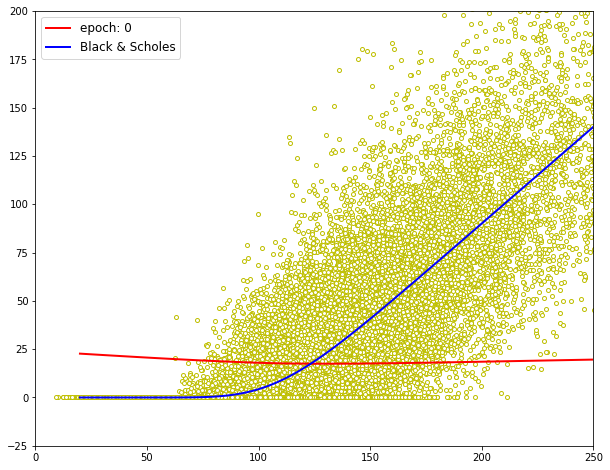

initial loss = 1.0071


In [0]:
# we train the network to best predict the ~normalized~ ys out of the ~normalized~ xs
feed_dict = {inputs:normX[:,np.newaxis], labels:normY[:,np.newaxis]}
# TensorFlow expects matrices (possibly with 1 column, not vectors, so we must reshape our vector data with np.newaxis)

display(0,sess)
print ("loss = %.4f" % sess.run(loss, feed_dict=feed_dict))

Lets try again but with 50 epochs

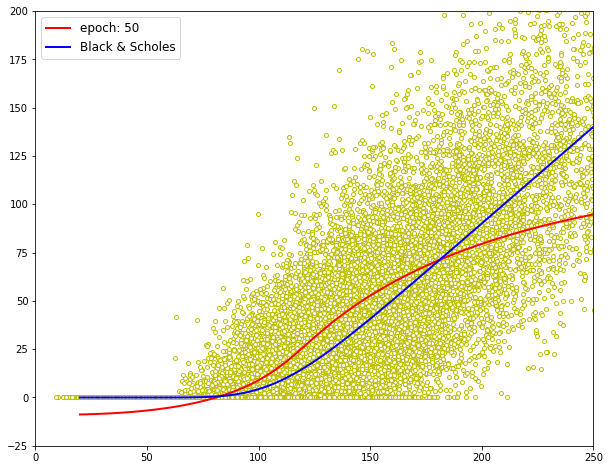

loss = 0.3778


In [0]:
# re-initialize
sess.run(tf.global_variables_initializer())

for _ in range(50):
    sess.run(optimize, feed_dict=feed_dict)

display(50, sess)
print ("loss = %.4f" % sess.run(loss, feed_dict=feed_dict))

Finally lets try with 1000 epochs

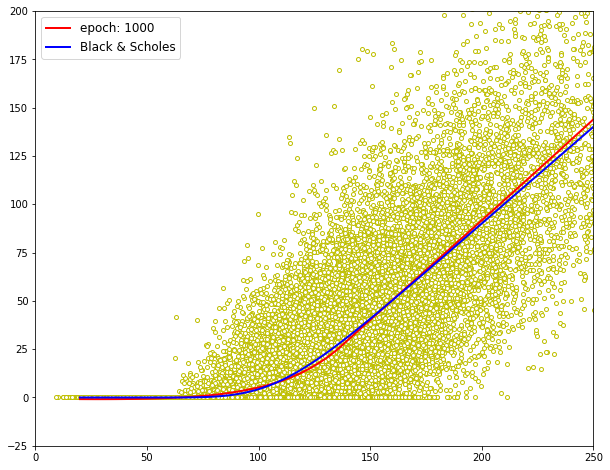

loss = 0.2071


In [0]:
# re-initialize
sess.run(tf.global_variables_initializer())

for _ in range(1000):
    sess.run(optimize, feed_dict=feed_dict)

display(1000, sess)
print ("loss = %.4f" % sess.run(loss, feed_dict=feed_dict))

In [0]:
sess.close()

We applied a few iterations of the naive gradient descent (GD) algorithm, which is actually not best practice (that would be SGD which should work faster).

The performance is generally similar to polynomial regression. The main benefit of deep learning is that it scales to high dimensional inputs, while the number of basis functions in conventional regression grows exponentially with the dimension of the input vector. In this example, dimension is 1 so neural nets don't make much difference, although it is interesting to visualize how they learn, and this also allowed us to implement our first ANN in a particularly simple context.